<a href="https://www.kaggle.com/concyclics/0-995-dog-or-cat-vgg-model-introduction?scriptVersionId=89422754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dog vs Cat Classification
#### Author: Concyclics
### ***Upvote*** me please if you thought it's helpful

## Content
In this notebook, we are going to use VGG pre-trained model to classify image of dog and cat and compare VGG16 and VGG19.

### Introduction to VGG model.
VGG was published by Visual Geometry Group in Oxford. this work is to investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. And VGG has several kinds of model, in this notebook, we only use VGG16 and VGG19 with 16 and 19 layers in depth.
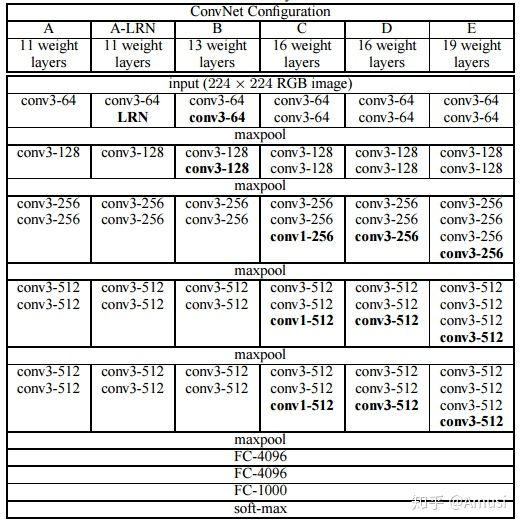


### Thoery Using 3\*3 instead of 5\*5 convolutions
You can see that when 2 3\*3 convolution layers full connected, it will have the same vision as a 5\*5 convolutions.

The result is similar when you use 3 layers 3\*3 to replace 7\*7 or 4 layers 3\*3 to replace 11\*11.

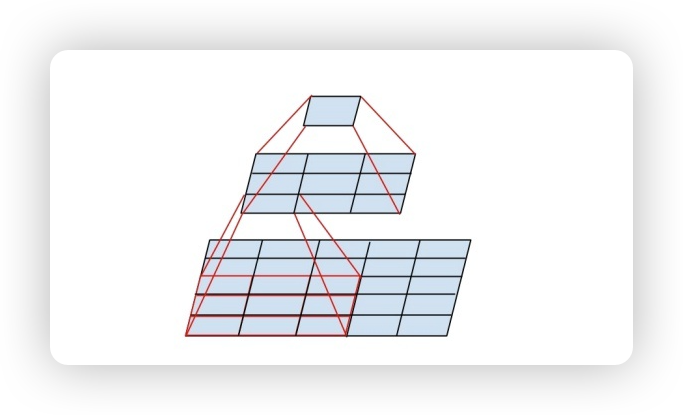

### Advantages and Disadvantages
* [Advantage]VGG models are concise with smaller 3\*3 convolutions.
* [Advantage]VGG proved the convolutional network depth make effort in accurarcy.
* [Disadvantage]VGG cost more memory since it has more parameters

#### VGG16
VGG16 was publised in 2014 and is one of the simplest (among the other cnn architectures used in Imagenet competition). It's Key Characteristics are:   

1. This network contains total 16 layers in which weights and bias parameters are learnt.    
2. A total of 13 convolutional layers are stacked one after the other and 3 dense layers for classification.     
3. The number of filters in the convolution layers follow an increasing pattern (similar to decoder architecture of autoencoder).     
4. The informative features are obtained by max pooling layers applied at different steps in the architecture.    
5. The dense layers comprises of 4096, 4096, and 1000 nodes each.   
6. The cons of this architecture are that it is slow to train and produces the model with very large size.   

The VGG16 architecture is given below: 

![](https://tech.showmax.com/2017/10/convnet-architectures/image_0-8fa3b810.png)

#### VGG19
VGG19 is a similar model architecure as VGG16 with three additional convolutional layers, it consists of a total of 16 Convolution layers and 3 dense layers. 

Following is the architecture of VGG19 model. In VGG networks, the use of 3 * 3 convolutions with stride 1 gives an effective receptive filed equivalent to 7 * 7. This means there are fewer parameters to train. 

![](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

## Implementation

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

### 1. Load datas

In [2]:
split=0.2
seed=19260817
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-03-06 14:43:30.670193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 14:43:30.786727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 14:43:30.787577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 14:43:30.792235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


#### 1.1 visualize some images

2022-03-06 14:43:39.011755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


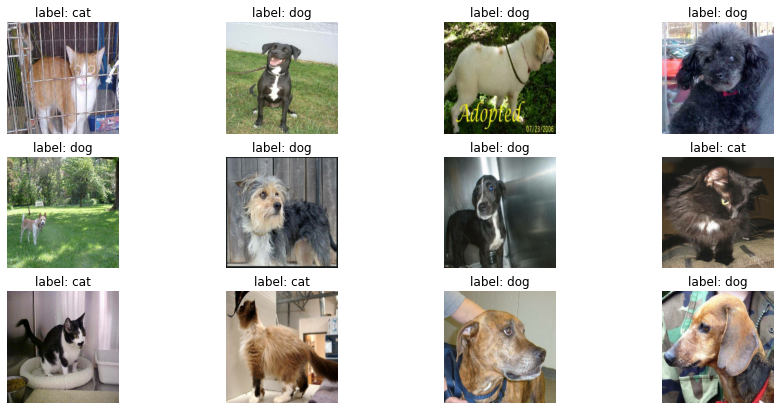

In [3]:
label_names={0:'cat',1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+label_names[label.numpy()[i]])
        #rint("label:", label.numpy()[i])
plt.show()

### 2. load VGG model

#### 2.1 history plot display

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

#### 2.2 augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.2),
        #layers.RandomTranslation(0.14,0.14),
        #layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

#### 2.3 callback

In [6]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=3)
]

#### 2.4 vgg16 model

In [7]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   

In [8]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               128455

In [9]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")


Epoch 1/100


2022-03-06 14:43:56.305476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 133s 1s/step - loss: 178.8475 - accuracy: 0.9309 - val_loss: 66.0913 - val_accuracy: 0.9828
Epoch 2/100
79/79 [==============================] - 67s 810ms/step - loss: 125.9245 - accuracy: 0.9768 - val_loss: 96.8476 - val_accuracy: 0.9848
Epoch 3/100
79/79 [==============================] - 67s 806ms/step - loss: 81.1508 - accuracy: 0.9850 - val_loss: 70.1643 - val_accuracy: 0.9856
Epoch 4/100
79/79 [==============================] - 66s 801ms/step - loss: 36.3413 - accuracy: 0.9905 - val_loss: 66.6759 - val_accuracy: 0.9838


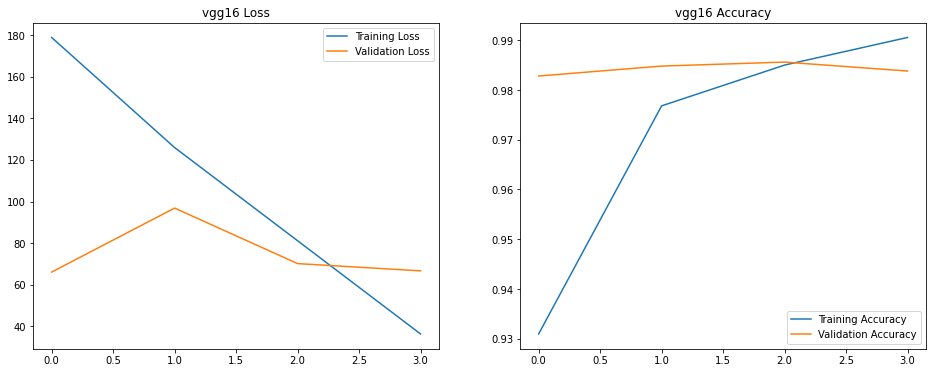

In [10]:
plot_history(history_vgg16,'vgg16')

#### 2.5 vgg19 model

In [11]:
vgg19_base  = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False)

#vgg19_base.trainable = True
vgg19_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg19_base.trainable_weights))

vgg19_base.summary()

80150528/80134624 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   

In [12]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = vgg19_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg19_model = keras.Model(inputs, outputs)
vgg19_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               128455

In [13]:
history_vgg19 = vgg19_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg19_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/100
79/79 [==============================] - 76s 917ms/step - loss: 1062.3125 - accuracy: 0.8474 - val_loss: 64.4671 - val_accuracy: 0.9746
Epoch 2/100
79/79 [==============================] - 74s 907ms/step - loss: 105.8572 - accuracy: 0.9611 - val_loss: 82.4500 - val_accuracy: 0.9868
Epoch 3/100
79/79 [==============================] - 75s 918ms/step - loss: 112.7647 - accuracy: 0.9725 - val_loss: 39.5534 - val_accuracy: 0.9856
Epoch 4/100
79/79 [==============================] - 75s 913ms/step - loss: 114.0029 - accuracy: 0.9742 - val_loss: 37.9528 - val_accuracy: 0.9862
Epoch 5/100
79/79 [==============================] - 74s 908ms/step - loss: 86.8870 - accuracy: 0.9793 - val_loss: 260.8850 - val_accuracy: 0.9586
Epoch 6/100
79/79 [==============================] - 75s 915ms/step - loss: 30.3237 - accuracy: 0.9892 - val_loss: 55.3957 - val_accuracy: 0.9860
Epoch 7/100
79/79 [==============================] - 74s 908ms/step - loss: 454.7773 - accuracy: 0.9647 - val_loss: 19

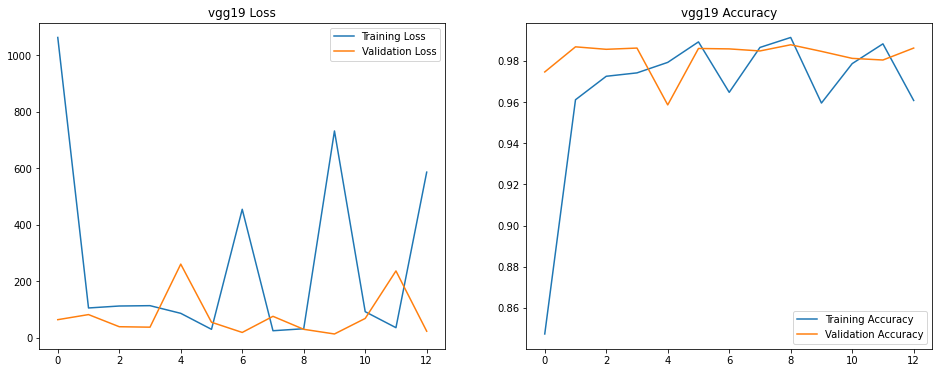

In [14]:
plot_history(history_vgg19,'vgg19')

### 3 Compare two models

In [15]:
vgg16_test=vgg16_model.evaluate(val_ds)
vgg19_test=vgg19_model.evaluate(val_ds)

20/20 [==============================] - 18s 746ms/step - loss: 13.9036 - accuracy: 0.9846


In [16]:
pd.set_option('precision',10)
compare_table=pd.DataFrame([vgg16_test,vgg19_test],columns=['loss','accuracy'],index=['vgg16','vgg19'])
cm = sns.light_palette("green", as_cmap=True)
compare_table.head().style.background_gradient(cmap=cm)

,loss,accuracy
vgg16,66.0912780762,0.9828000069
vgg19,13.9035596848,0.9846000075


In [17]:
if vgg16_test[1]>vgg19_test[1]:
    model=vgg16_model
else:
    model=vgg19_model

### 4. Prediction

#### 4.1 prepare testing data

In [18]:
import os
test_filenames = os.listdir("../input/dog-vs-cat-classification/test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

8000

In [19]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dog-vs-cat-classification/test/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


#### 4.2 predict and view

In [20]:
predict = model.predict(test_generator)
test_df['labels'] = np.argmax(predict, axis=-1)

In [21]:
test_df

,id,labels
0,005463.jpg,1
1,000304.jpg,1
2,001940.jpg,1
3,007289.jpg,1
4,005491.jpg,0
...,...,...
7995,004881.jpg,0
7996,003638.jpg,0
7997,007845.jpg,0
7998,007882.jpg,1


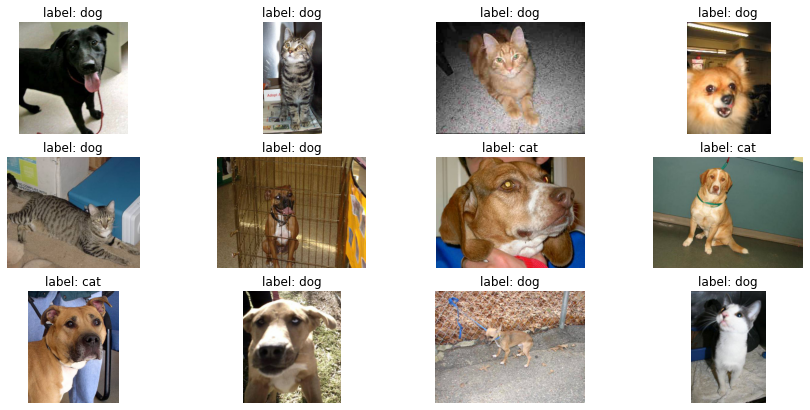

In [22]:
label_names={0:'cat',1:'dog'}
fig, ax = plt.subplots(figsize=(15, 7))
i=0
for index, row in test_df.sample(12).iterrows():
    i+=1
    plt.subplot(3, 4,i)
    img=plt.imread('../input/dog-vs-cat-classification/test/test/'+row['id'])
    plt.imshow(img)
    plt.axis("off")
    plt.title("label: "+label_names[label.numpy()[i]])
    #rint("label:", label.numpy()[i])
plt.show()

#### 4.3 submit

In [23]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)

## Conclusion

Above all, we can find vgg19 mostly works better but they are very similar.

## Reference
1. https://www.kaggle.com/concyclics/cnn-architectures-vgg-resnet-inception-tl/edit
2. https://zhuanlan.zhihu.com/p/41423739